In [1]:
import torch
import argparse
import os
    
import utils
import model

from torch.utils.data import DataLoader
from data_multi import PolyphonicDataset 

import nltk
import numpy as np
import matplotlib.pyplot as plt

c:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Le présent notebook contient le code utiliser pour évaluer la performance des modèles. C'est aussi sur ce dernier que sont créés différentes visualisations de la performance.

# RNN Decoder

In [2]:
path_to_model=""

In [3]:
#params = model.default_model_params()
corpus="./Dataset/"
voc_p="./vocab/rnn_pitch.txt"
voc_r="./vocab/rnn_rhythm.txt"

Récupération du vocabulaire pour le pitch et le rythme

In [4]:
dict_file = open(voc_p,'r')
dict_list = dict_file.read().splitlines()
pitch_word2int = dict()
i=0
for word in dict_list:
    pitch_word2int[word] = i
    i+=1
pitch_word2int['+']=i
dict_file.close()

In [5]:
dict_file = open(voc_r,'r')
dict_list = dict_file.read().splitlines()
rhythm_word2int = dict()
i=0
for word in dict_list:
    rhythm_word2int[word] = i
    i+=1
rhythm_word2int['+']=i
dict_file.close()

On calcul le pourcentage de sequence polyphonique dans le dataset

In [6]:
gt_rhythm_folder=corpus+"labels_length/"
with open(corpus+"test.txt", 'r') as f:
    test_files=[file + ".semantic" for file in f.read().split()]
    f.close()
polyphonic_seq=0

#Sur tout les fichiers de l'ensemble de test
for file_name in test_files:
    c=0 # Compte le nombre de symbole pour un "accord". 
    is_polyphonic=False #indique si une sequence contient un élement polyphonique ou non
    try:
        with open(gt_rhythm_folder+file_name, 'r') as f:
            for label in f.read().strip().split(" "):
                if c>1:
                    is_polyphonic=True
                if label=="+":
                    c=0
                else:
                    c+=1
    except FileNotFoundError:
        continue
    if is_polyphonic:
        polyphonic_seq+=1

In [7]:
print("Ratio de sequences polyphoniques sur l'ensemble des séquences: "+str(polyphonic_seq/len(test_files)))

Ratio de sequences polyphoniques sur l'ensemble des séquences: 0.4855813953488372


On implémente la fonction qui nous donnera le SER total, le SER pour le pitch/le rythme, le SER pour le pitch/le rythme sur les sequences avec une polyphonie.

In [8]:
def get_result(model_pred_folder):
    output_folder="./prediction/"
    pred_rhythm_folder=output_folder+model_pred_folder+"rythm/"
    pred_pitch_folder=output_folder+model_pred_folder+"pitch/"

    gt_rhythm_folder=corpus+"labels_length/"
    gt_pitch_folder=corpus+"labels_note/"

    with open(corpus+"test.txt", 'r') as f:
        test_files=[file + ".semantic" for file in f.read().split()]
        f.close()
    # Calculate SER of all test files
    SER_rhythm_list=[]
    SER_pitch_list=[]
    SER_pitch_list_poly=[]
    SER_rhythm_list_poly=[]
    SER_list=[]
    polyphonic_seq=0
    for file_name in test_files:
        gt_rhythm_int=[]
        pred_rhythm_int=[]
        gt_pitch_int=[]
        pred_pitch_int=[]
        c=0 # Compte le nombre de symbole pour un "accord"
        is_polyphonic=False # indique si une sequence contient un élement polyphonique ou non
        try:
            with open(gt_rhythm_folder+file_name, 'r') as f:
                for label in f.read().strip().split(" "):
                    if c>1:
                        is_polyphonic=True
                    if label=="+":
                        c=0
                    else:
                        c+=1
                    try:
                        gt_rhythm_int.append(rhythm_word2int[label])
                    except KeyError:
                        gt_rhythm_int.append(np.inf)
                    
                
                f.close()
            with open(pred_rhythm_folder+file_name, 'r') as f:
                for label in f.read().strip().split(" "):
                    pred_rhythm_int.append(rhythm_word2int[label])        
                f.close()

            with open(gt_pitch_folder+file_name, 'r') as f:
                for label in f.read().strip().split(" "):
                    try:
                        gt_pitch_int.append(pitch_word2int[label])
                    except KeyError:
                        gt_pitch_int.append(np.inf)
                f.close()
            with open(pred_pitch_folder+file_name, 'r') as f:
                for label in f.read().strip().split(" "):
                    pred_pitch_int.append(pitch_word2int[label])   
                f.close()

            # distance d'édition entre la prédiction et la vérité terrain pour le rythme
            dist_rhythm=nltk.edit_distance(pred_rhythm_int,gt_rhythm_int)
            SER_rhythm=dist_rhythm/max(len(gt_rhythm_int),len(pred_rhythm_int))
            SER_rhythm_list.append(SER_rhythm)

            # distance d'édition entre la prédiction et la vérité terrain pour la hauteur
            dist_pitch=nltk.edit_distance(pred_pitch_int,gt_pitch_int)
            SER_pitch=dist_pitch/max(len(gt_pitch_int),len(pred_pitch_int))
            SER_pitch_list.append(SER_pitch)

            # SER total (rythme et pitch)
            SER_tot=(dist_rhythm+dist_pitch)/max(len(gt_pitch_int)+len(gt_rhythm_int),len(pred_pitch_int)+len(pred_rhythm_int))
            SER_list.append(SER_tot)
            
            # On stocke séparemment les SER qui concerne uniquement les passages polyphoniques
            if is_polyphonic:
                SER_pitch_list_poly.append(SER_pitch)
                SER_rhythm_list_poly.append(SER_rhythm)

        except FileNotFoundError:
            continue
        if is_polyphonic:
            polyphonic_seq+=1
    return SER_rhythm_list,SER_pitch_list,SER_pitch_list_poly,SER_rhythm_list_poly,SER_list,polyphonic_seq

In [18]:
output_folder="./prediction/"
model_pred_folder="./predictionFaSolLa/"
pred_rhythm_folder=output_folder+model_pred_folder+"rythm/"
pred_pitch_folder=output_folder+model_pred_folder+"pitch/"

gt_rhythm_folder=corpus+"labels_length/"
gt_pitch_folder=corpus+"labels_note/"

with open(corpus+"test.txt", 'r') as f:
    test_files=[file + ".semantic" for file in f.read().split()]
    f.close()

#### Modèle des auteurs

In [53]:
model_pred_folder="./prediction_pretrain_model/"
SER_rhythm_list_vo,SER_pitch_list_vo,SER_pitch_list_poly_vo,SER_rhythm_list_poly_vo,SER_list_vo,polyphonic_seq=get_result(model_pred_folder)

In [54]:
print("Moyenne SER pour le pitch sur sequence avec polyphonie: "+str(np.mean(SER_pitch_list_poly_vo)))
print("Moyenne SER pour le rythme sur sequence avec polyphonie: "+str(np.mean(SER_rhythm_list_poly_vo)))
print("Moyenne SER pour le rythme:  "+str(np.mean(SER_rhythm_list_vo)))
print("Moyenne SER pour le pitch:  "+str(np.mean(SER_pitch_list_vo)))

Moyenne SER pour le pitch sur sequence avec polyphonie: 0.3436053944987844
Moyenne SER pour le rythme sur sequence avec polyphonie: 0.08662654620786844
Moyenne SER pour le rythme:  0.04826676300014128
Moyenne SER pour le pitch:  0.22425004583667116


### FaSolLa

On compare les 4 modèles du RNNDecoder, entrainé sur l'ensemble de donnée FaSolLa: l'original et nos 3 tentatives de modification.

#### V1 (original)

In [64]:
model_pred_folder="./predictionFaSolLa/"
SER_rhythm_list_v1,SER_pitch_list_v1,SER_pitch_list_poly_v1,SER_rhythm_list_poly_v1,SER_list_v1,polyphonic_seq=get_result(model_pred_folder)

In [65]:
print("Moyenne SER pour le pitch sur sequence avec polyphonie: "+str(np.mean(SER_pitch_list_poly_v1)))
print("Moyenne SER pour le rythme sur sequence avec polyphonie: "+str(np.mean(SER_rhythm_list_poly_v1)))
print("Moyenne SER pour le rythme:  "+str(np.mean(SER_rhythm_list_v1)))
print("Moyenne SER pour le pitch:  "+str(np.mean(SER_pitch_list_v1)))

Moyenne SER pour le pitch sur sequence avec polyphonie: 0.381244855126756
Moyenne SER pour le rythme sur sequence avec polyphonie: 0.17919545200496328
Moyenne SER pour le rythme:  0.09645869326969492
Moyenne SER pour le pitch:  0.21397831194322203


#### V1 entrainé sur 25 epoch

In [56]:
model_pred_folder="./prediction-25epoch/"
SER_rhythm_list_v1_25ep,SER_pitch_list_v1_25ep,SER_pitch_list_poly_v1_25ep,SER_rhythm_list_poly_v1_25ep,SER_list_v1_25ep,polyphonic_seq=get_result(model_pred_folder)

In [57]:
print("Moyenne SER pour le pitch sur sequence avec polyphonie: "+str(np.mean(SER_pitch_list_poly_v1_25ep)))
print("Moyenne SER pour le rythme sur sequence avec polyphonie: "+str(np.mean(SER_rhythm_list_poly_v1_25ep)))
print("Moyenne SER pour le rythme:  "+str(np.mean(SER_rhythm_list_v1_25ep)))
print("Moyenne SER pour le pitch:  "+str(np.mean(SER_pitch_list_v1_25ep)))

Moyenne SER pour le pitch sur sequence avec polyphonie: 0.3270668068512549
Moyenne SER pour le rythme sur sequence avec polyphonie: 0.14049878899896007
Moyenne SER pour le rythme:  0.10120184474034677
Moyenne SER pour le pitch:  0.248855866604339


#### V2: concaténation des vecteurs cachés du rythme et de la hauteur en entrée du décodeur.

In [31]:
model_pred_folder="./prediction-variation-v2/"
SER_rhythm_list_v2,SER_pitch_list_v2,SER_pitch_list_poly_v2,SER_rhythm_list_poly_v2,SER_list_v2,polyphonic_seq=get_result(model_pred_folder)

In [32]:
print("Moyenne SER pour le pitch sur sequence avec polyphonie: "+str(np.mean(SER_pitch_list_poly_v2)))
print("Moyenne SER pour le rythme sur sequence avec polyphonie: "+str(np.mean(SER_rhythm_list_poly_v2)))
print("Moyenne SER pour le rythme:  "+str(np.mean(SER_rhythm_list_v2)))
print("Moyenne SER pour le pitch:  "+str(np.mean(SER_pitch_list_v2)))

Moyenne SER pour le pitch sur sequence avec polyphonie: 0.3560205684686561
Moyenne SER pour le rythme sur sequence avec polyphonie: 0.13930587728761612
Moyenne SER pour le rythme:  0.10407392318851606
Moyenne SER pour le pitch:  0.2760060672817365


#### V3: décodage bi-directionnel

In [33]:
model_pred_folder="./prediction-variation-v3/"
SER_rhythm_list_v3,SER_pitch_list_v3,SER_pitch_list_poly_v3,SER_rhythm_list_poly_v3,SER_list_v3,polyphonic_seq=get_result(model_pred_folder)

In [34]:
print("Moyenne SER pour le pitch sur sequence avec polyphonie: "+str(np.mean(SER_pitch_list_poly_v3)))
print("Moyenne SER pour le rythme sur sequence avec polyphonie: "+str(np.mean(SER_rhythm_list_poly_v3)))
print("Moyenne SER pour le rythme:  "+str(np.mean(SER_rhythm_list_v3)))
print("Moyenne SER pour le pitch:  "+str(np.mean(SER_pitch_list_v3)))

Moyenne SER pour le pitch sur sequence avec polyphonie: 0.39199271388578755
Moyenne SER pour le rythme sur sequence avec polyphonie: 0.18974053819075523
Moyenne SER pour le rythme:  0.13720199697394728
Moyenne SER pour le pitch:  0.30309045864619094


#### V4: vecteurs cachés de la séquence précédemment décodé en entrée du décodage de la séquence suivante.

In [35]:
model_pred_folder="./prediction-variation-v4/"
SER_rhythm_list_v4,SER_pitch_list_v4,SER_pitch_list_poly_v4,SER_rhythm_list_poly_v4,SER_list_v4,polyphonic_seq=get_result(model_pred_folder)

In [36]:
print("Moyenne SER pour le pitch sur sequence avec polyphonie: "+str(np.mean(SER_pitch_list_poly_v4)))
print("Moyenne SER pour le rythme sur sequence avec polyphonie: "+str(np.mean(SER_rhythm_list_poly_v4)))
print("Moyenne SER pour le rythme:  "+str(np.mean(SER_rhythm_list_v4)))
print("Moyenne SER pour le pitch:  "+str(np.mean(SER_pitch_list_v4)))

Moyenne SER pour le pitch sur sequence avec polyphonie: 0.36213540587434884
Moyenne SER pour le rythme sur sequence avec polyphonie: 0.1392863419260373
Moyenne SER pour le rythme:  0.10453201702728038
Moyenne SER pour le pitch:  0.2814048728278175


#### Visualisations

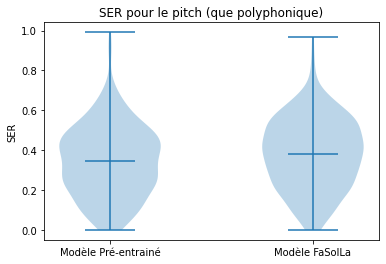

In [66]:
plt.violinplot([SER_pitch_list_poly_vo,SER_pitch_list_poly_v1],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2],labels=["Modèle Pré-entrainé","Modèle FaSolLa"])
plt.ylabel("SER")
plt.title("SER pour le pitch (que polyphonique)")
plt.show()

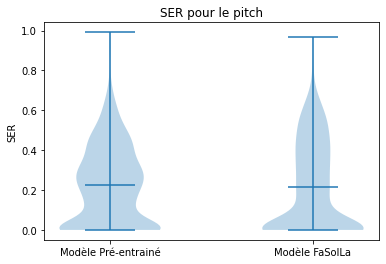

In [67]:
plt.violinplot([SER_pitch_list_vo,SER_pitch_list_v1],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2],labels=["Modèle Pré-entrainé","Modèle FaSolLa"])
plt.ylabel("SER")
plt.title("SER pour le pitch")
plt.show()

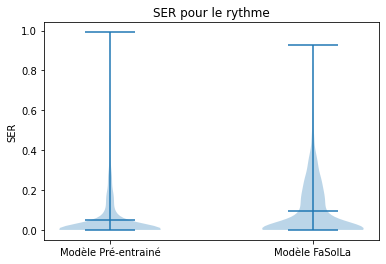

In [69]:
plt.violinplot([SER_rhythm_list_vo,SER_rhythm_list_v1],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2],labels=["Modèle Pré-entrainé","Modèle FaSolLa"])
plt.ylabel("SER")
plt.title("SER pour le rythme")
plt.show()

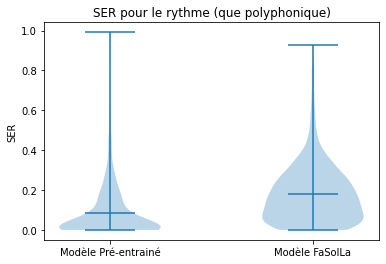

In [70]:
plt.violinplot([SER_rhythm_list_poly_vo,SER_rhythm_list_poly_v1],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2],labels=["Modèle Pré-entrainé","Modèle FaSolLa"])
plt.ylabel("SER")
plt.title("SER pour le rythme (que polyphonique)")
plt.show()

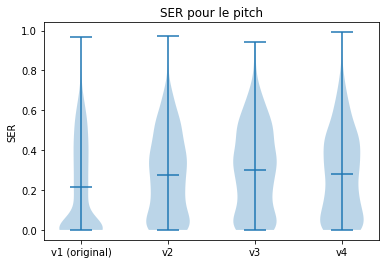

In [45]:
plt.violinplot([SER_pitch_list_v1,SER_pitch_list_v2,SER_pitch_list_v3,SER_pitch_list_v4],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2,3,4],labels=["v1 (original)","v2","v3","v4"])
plt.ylabel("SER")
plt.title("SER pour le pitch")
plt.show()

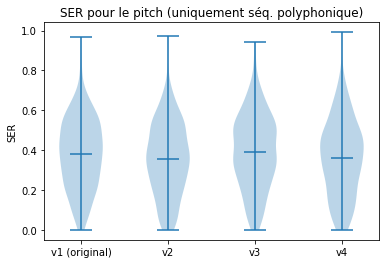

In [49]:
plt.violinplot([SER_pitch_list_poly_v1,SER_pitch_list_poly_v2,SER_pitch_list_poly_v3,SER_pitch_list_poly_v4],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2,3,4],labels=["v1 (original)","v2","v3","v4"])
plt.ylabel("SER")
plt.title("SER pour le pitch (uniquement séq. polyphonique)")
plt.show()

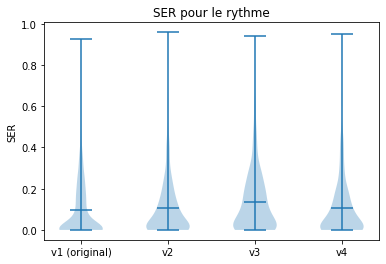

In [50]:
plt.violinplot([SER_rhythm_list_v1,SER_rhythm_list_v2,SER_rhythm_list_v3,SER_rhythm_list_v4],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2,3,4],labels=["v1 (original)","v2","v3","v4"])
plt.ylabel("SER")
plt.title("SER pour le rythme")
plt.show()

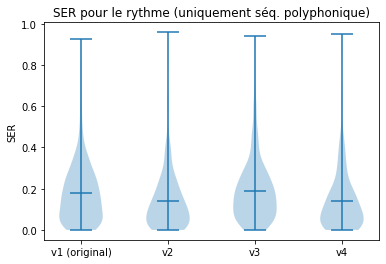

In [51]:
plt.violinplot([SER_rhythm_list_poly_v1,SER_rhythm_list_poly_v2,SER_rhythm_list_poly_v3,SER_rhythm_list_poly_v4],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2,3,4],labels=["v1 (original)","v2","v3","v4"])
plt.ylabel("SER")
plt.title("SER pour le rythme (uniquement séq. polyphonique)")
plt.show()

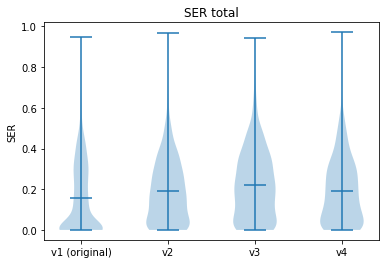

In [38]:
plt.violinplot([SER_list_v1,SER_list_v2,SER_list_v3,SER_list_v4],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2,3,4],labels=["v1 (original)","v2","v3","v4"])
plt.ylabel("SER")
plt.title("SER total")
plt.show()

### DoReMi

In [40]:
model_pred_folder="./predictionDoReMi/"
SER_rhythm_list,SER_pitch_list,SER_pitch_list_poly,SER_rhythm_list_poly,SER_list,polyphonic_seq=get_result(model_pred_folder)

In [41]:
print("Moyenne SER pour le pitch sur sequence avec polyphonie: "+str(np.mean(SER_pitch_list_poly)))
print("Moyenne SER pour le rythme sur sequence avec polyphonie: "+str(np.mean(SER_rhythm_list_poly)))
print("Moyenne SER pour le rythme:  "+str(np.mean(SER_rhythm_list)))
print("Moyenne SER pour le pitch:  "+str(np.mean(SER_pitch_list)))

Moyenne SER pour le pitch sur sequence avec polyphonie: 0.6613408119556714
Moyenne SER pour le rythme sur sequence avec polyphonie: 0.465695118776459
Moyenne SER pour le rythme:  0.2842902954124691
Moyenne SER pour le pitch:  0.40391224633141953


In [42]:
SER_list_pitch_DoReMi=SER_pitch_list
SER_list_rhythm_DoReMi=SER_rhythm_list
SER_pitch_list_poly_DoReMi=SER_pitch_list_poly
SER_rhythm_list_poly_DoReMi=SER_rhythm_list_poly

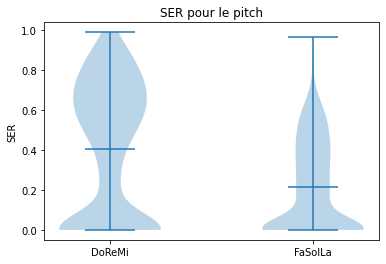

In [44]:
plt.violinplot([SER_list_pitch_DoReMi,SER_pitch_list_v1],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2],labels=["DoReMi","FaSolLa"])
plt.ylabel("SER")
plt.title("SER pour le pitch")
plt.show()

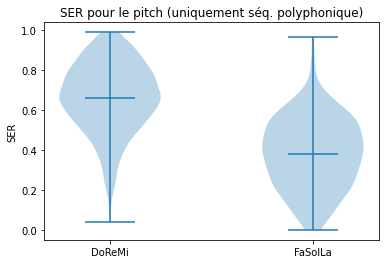

In [45]:
plt.violinplot([SER_pitch_list_poly_DoReMi,SER_pitch_list_poly_v1],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2],labels=["DoReMi","FaSolLa"])
plt.ylabel("SER")
plt.title("SER pour le pitch (uniquement séq. polyphonique)")
plt.show()

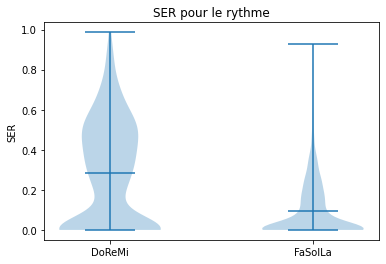

In [46]:
plt.violinplot([SER_list_rhythm_DoReMi,SER_rhythm_list_v1],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2],labels=["DoReMi","FaSolLa"])
plt.ylabel("SER")
plt.title("SER pour le rythme")
plt.show()

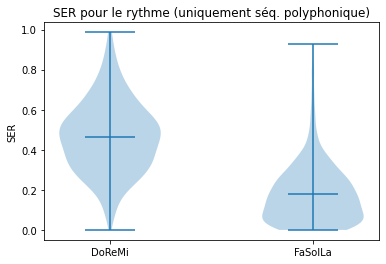

In [47]:
plt.violinplot([SER_rhythm_list_poly_DoReMi,SER_rhythm_list_poly_v1],showmeans=True,showextrema=True)
plt.xticks(ticks=[1,2],labels=["DoReMi","FaSolLa"])
plt.ylabel("SER")
plt.title("SER pour le rythme (uniquement séq. polyphonique)")
plt.show()